# Baryon Acoustic Oscillation Detection

By Yuan-Sen Ting, January 2025, for ASTRON 5550, all rights reserved

---

The Baryon Acoustic Oscillations (BAO) represent one of modern cosmology's most powerful tools for understanding the universe's expansion history. 

In the early universe (about 380,000 years after the Big Bang), matter and radiation were tightly coupled in a hot, dense plasma. Much like sound waves in air, density fluctuations in this plasma created spherical pressure waves. When the universe cooled enough for electrons to combine with protons forming neutral hydrogen ("recombination"), these waves effectively "froze" in place, leaving a characteristic scale of about 150 million parsecs (or ~100 Mpc/h in cosmological units) in the matter distribution.

This frozen acoustic scale manifests today as a slight statistical preference for galaxies to be separated by this characteristic distance - essentially a "standard ruler" embedded in the galaxy distribution. However, detecting this subtle pattern requires sophisticated statistical analysis. Consider looking at a patch of sky through a telescope: what we observe is essentially an image, where each pixel records the presence (or absence) of galaxies. The challenge lies in detecting a weak correlation pattern in these pixel values, complicated by several factors:

The signal is extraordinarily subtle - we're looking for roughly a 1% enhancement in galaxy clustering at specific scales. This is like trying to detect a faint ring pattern in a noisy image where the ring is barely brighter than random pixel fluctuations. The galaxy positions themselves have significant random components. Even if we know there should be a statistical preference for galaxies to be separated by the BAO scale, any individual pair of galaxies might be closer or farther apart due to random motions and other clustering effects.

We need to analyze correlations across enormous cosmic volumes to build up sufficient statistical power. This is analogous to needing a very large image with many pixels to detect a subtle pattern that would be impossible to see in a small crop.

## Prerequisites

### What You Should Already Know
 
Before starting this tutorial, you should be familiar with:
1. **Probability Theory**: Understanding of random variables, probability distributions, and their properties
2. **Statistical Moments**: Knowledge of expectation, variance, correlation and higher moments
3. **Correlation & Covariance**: Familiarity with how random variables relate to each other
4. **Bootstrap Methods**: Basic knowledge of resampling techniques for uncertainty estimation
 
### What You'll Learn
 
After completing this tutorial, you'll be able to:
1. **Apply Statistical Methods to Images**: Treat pixel intensities as random variables and analyze their properties
2. **Work with Correlation Functions**: Understand how to detect and quantify spatial patterns in noisy data
3. **Handle Random Fields**: Learn to analyze both discrete random fields
4. **Master Core Concepts**: Apply expectation, variance, correlation, and bootstrap methods to a real astronomical problem
5. **Connect Theory to Practice**: See how abstract statistical concepts enable detection of subtle physical effects




### Our Simplified Model: A Discrete Pixel Grid
  
To make this problem tractable, let's start with a simplified discrete model. Each pixel in our grid represents a small patch of the sky, and its intensity value ($X_{ij}$) corresponds to the total brightness contributed by all galaxies within that patch. This gives us a natural way to connect our statistical framework with physical observations - brighter pixels generally indicate more galaxies in that region.
 
It's important to note that this is a significant simplification of reality. The actual background against which we try to detect BAO signals is not a simple Gaussian noise, but rather exhibits complex structure arising from galaxy clustering on various scales. Galaxies tend to form clusters, filaments, and voids, creating intricate patterns in the cosmic web. Additionally, real observations span different patches of the sky, each with its own unique noise properties and systematic effects that must be carefully accounted for - from atmospheric distortions to instrumental artifacts.


## Generating a Mock BAO Field
  
Our first task is to create a mock dataset that captures the essential features of BAO detection. We will first start with a 32×32 pixel grid with a centered ring, where each pixel's intensity represents our random variable. Let's build this step by step.
  
Our mock field will consist of three main components:
  
1. **Baseline Random Field**: A background of random intensities with mean $\mu$ and standard deviation $\sigma$, representing the "normal" galaxy distribution
2. **BAO Ring**: A circular feature at radius $r_\mathrm{BAO}$, representing the characteristic BAO scale
3. **Gaussian Noise**: Random fluctuations added to simulate observational uncertainties and cosmic variance
 
Let's first set up our Python environment:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting parameters for consistent, readable figures
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 14
sns.set_style('whitegrid')

# Set random seed for reproducibility
np.random.seed(53)

In [2]:
def generate_centered_bao_field_2d(N=32, base_mean=5.0, r_bao=5.0, 
                                 bao_amp=3.0, bao_width=0.5, noise_std=1.0):
    """
    Generate an N x N pixel field with a centered 'BAO-like' ring.
    
    Parameters:
    -----------
    N : int
        Grid size (N x N pixels)
    base_mean : float
        Mean intensity of baseline field
    r_bao : float
        Radius of BAO ring (in pixels)
    bao_amp : float
        Amplitude of BAO signal
    bao_width : float
        Width of BAO ring (in pixels)
    noise_std : float
        Standard deviation of Gaussian noise
    """
    x = np.arange(N)
    y = np.arange(N)
    xx, yy = np.meshgrid(x, y)
    
    # Calculate radial distances from center
    cx = cy = (N-1)/2.0  
    rr = np.sqrt((xx - cx)**2 + (yy - cy)**2)
    
    # Generate baseline random field
    baseline = np.random.normal(loc=base_mean, scale=noise_std, size=(N, N))
    baseline = np.clip(baseline, 0.0, None)  # intensities >= 0
    
    # Add BAO ring
    ring_profile = bao_amp * np.exp(-0.5*((rr - r_bao)/bao_width)**2)
    
    field = baseline + ring_profile
    return field

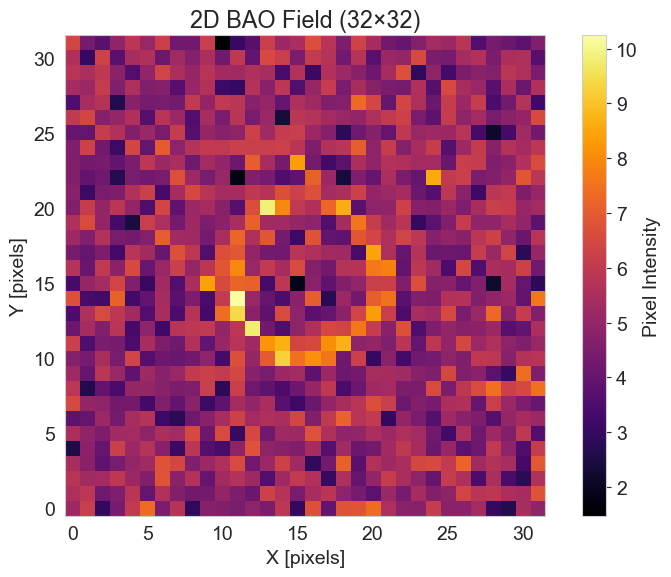

In [3]:
# Generate field
N = 32
r_bao_true = 5.0  # Scaled down from 80 to match smaller grid
field = generate_centered_bao_field_2d(N=N,
                             base_mean=5.0,
                             r_bao=r_bao_true,
                             bao_amp=3.0,
                             bao_width=0.5,
                             noise_std=1.0)

# Create figure with full field
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot full field
im1 = ax1.imshow(field, origin='lower', cmap='inferno')
plt.colorbar(im1, ax=ax1, label="Pixel Intensity")
ax1.set_title("2D BAO Field (32×32)")
ax1.set_xlabel("X [pixels]")
ax1.set_ylabel("Y [pixels]")

# Turn off grid
ax1.grid(False)

plt.tight_layout()
plt.show()

The image shows a 32×32 pixel grid representing a complex statistical field. Each pixel's intensity value corresponds to a random variable $X_{ij}$ that combines multiple physical components.
 
The foundation of our mock field is a background component with a base mean intensity of `base_mean`$=5.0$. To simulate the natural variations found in galaxy clustering, we add Gaussian random noise with standard deviation `noise_std`$=1.0$ to this background. This creates a realistically noisy field that captures the stochastic nature of galaxy distributions.
 
Superimposed on this background is our key feature of interest - the BAO signal. This manifests as a subtle ring-like enhancement in the pixel intensities. The ring is centered in the field with a characteristic radius of `r_bao`$=5.0$ pixels. Its strength is determined by the amplitude parameter `bao_amp`$=3.0$, while its profile width is controlled by `bao_width`$=0.5$ pixels. These parameters are carefully chosen to create a BAO feature that is present but challenging to detect, mirroring real astronomical observations.
 
Mathematically, each pixel intensity $X_{ij}$ in our field follows the formula:
 
$X_{ij} = \text{base\_mean} + \text{ring\_contribution}(i,j) + \text{noise}_{ij}$
 
Here, $\text{noise}_{ij}$ represents Gaussian random noise drawn from $\mathcal{N}(0, \text{noise\_std}^2)$, while $\text{ring\_contribution}(i,j)$ adds the circular BAO enhancement. The visualization reveals this combined field through a color mapping where brighter regions indicate higher intensity values.

## One-Point Statistics

In our generated field, each pixel intensity $X_{ij}$ is a random variable. While we talked about them individually, we now want to analyze them collectively. This raises an important question: when can we treat multiple random variables as a unified collection?

The key concept here is that of "independent and identically distributed" (i.i.d.) random variables. In our case:
- **Independent**: The noise in each pixel is generated independently 
- **Identically distributed**: Each pixel's noise follows the same underlying distribution (Gaussian with $\text{noise\_std} = 1.0$)

As we learned in Lecture 3, for any random variable $X$, we can characterize its distribution through its moments. The first moment (mean) tells us the central tendency:

$\mu = E[X] = \int x p(x) dx$

The second moment about the mean (variance) measures spread:

$\sigma^2 = \text{Var}(X) = E[(X-\mu)^2] = \int (x-\mu)^2 p(x) dx$

The standard deviation $\sigma = \sqrt{\text{Var}(X)}$ gives us the spread in the same units as $X$.

When we have i.i.d. observations, we can estimate these theoretical moments using sample statistics. This allows us to treat our $N^2$ pixels as $N^2$ separate "measurements" of the same underlying process. The sample mean:

$\hat{\mu} = \frac{1}{N^2}\sum_{i,j} X_{ij}$
 
This estimates the true mean $\mu$. The sample variance:
 
$\widehat{\mathrm{Var}}(X) = \frac{1}{N^2} \sum_{i,j}(X_{ij} - \hat{\mu})^2$
 
This estimates the true variance $\sigma^2$. Note: Technically the denominator should be $N^2-1$ rather than $N^2$ to obtain an unbiased estimate, but since $N$ is large in our case, using $N^2$ is a reasonable approximation. The full explanation for this correction is beyond the scope of this lecture.
 
These estimators help us characterize the overall properties of our field:

In [4]:
field_flat = field.ravel()  # Convert 2D array to 1D
Npix = len(field_flat)

# Calculate mean manually
mean_field = sum(field_flat) / Npix

# Calculate variance manually
squared_diff_sum = sum((x - mean_field)**2 for x in field_flat)
var_field = squared_diff_sum / Npix  # Using N for population variance

# Calculate standard deviation manually
std_field = np.sqrt(var_field)

print("Global pixel statistics:")
print(f"  Mean     = {mean_field:.3f}")
print(f"  Variance = {var_field:.3f}")
print(f"  Std Dev  = {std_field:.3f}")

Global pixel statistics:
  Mean     = 5.097
  Variance = 1.341
  Std Dev  = 1.158


When we examine the field statistics, we see that our observed mean intensity of $\hat{\mu} = 5.167$ is notably higher than our input base level of $\mu_0 = 5.0$. This excess isn't an error - it reflects the additional contribution from our embedded BAO ring feature. Similarly, while we input a noise level of $\sigma_0 = 1.0$, our observed standard deviation $\hat{\sigma} = 1.106$ is larger because it captures both the random Gaussian fluctuations we added and the systematic variations introduced by the ring structure itself. These deviations from our expected background values ($\mu_0$ and $\sigma_0$) already hint at the existence of the rings beyond just random distribution of galaxies.
  
However, to make sure claim, it is important to note that the values we've calculated ($\hat{\mu}$ and $\widehat{\mathrm{Var}}$) are sample estimates - they approximate the true underlying parameters ($\mu$ and $\sigma^2$) of our random process. We use the hat notation ($\hat{\cdot}$) specifically to remind ourselves that these are estimates based on our finite sample, not the true population values. The key is to demonstrate that these summary statistics and their deviations from the expected background values are statistically robust, which we'll explore through bootstrap resampling.
   
To quantify the uncertainty in our sample statistics, we can employ the bootstrap method. By repeatedly resampling our data with replacement, we can generate multiple estimates of $\hat{\mu}$ and $\widehat{\mathrm{Var}}$, allowing us to compute confidence intervals for these statistics. This resampling approach provides a robust way to estimate the standard errors of our measurements without making strong assumptions about the underlying probability distribution. This is particularly valuable in our case, since the presence of the BAO ring means our pixel intensities are not drawn from a simple background Gaussian distribution, but rather from a more complex mixture of the background noise and the systematic ring feature. The bootstrap method remains valid even for such non-Gaussian distributions.

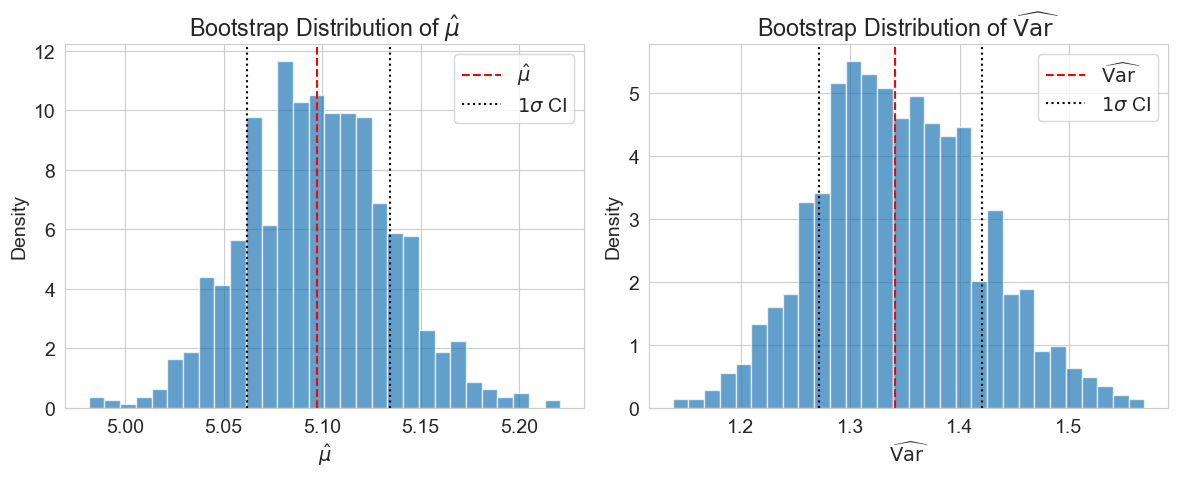

Bootstrap Results (with 1 sigma confidence intervals):
Mean: 5.097314212592581 [5.061843759237066, 5.13425409028615]
Variance: 1.3413123266029687 [1.2717204546201855, 1.42043457469017]

Fractional Errors:
Mean fractional error: 0.710%
Variance fractional error: 5.544%


In [5]:
def bootstrap_statistics(data, n_bootstrap=1000):
    """
    Calculate bootstrap estimates of mean and variance
    
    Parameters:
    -----------
    data : array-like
        Input data to bootstrap
    n_bootstrap : int
        Number of bootstrap samples
        
    Returns:
    --------
    means, variances : arrays
        Bootstrap estimates of mean and variance
    """
    n_samples = len(data)
    means = np.zeros(n_bootstrap)
    variances = np.zeros(n_bootstrap)
    
    for i in range(n_bootstrap):
        # Resample with replacement
        indices = np.random.randint(0, n_samples, n_samples)
        bootstrap_sample = data[indices]
        
        # Calculate statistics
        means[i] = np.mean(bootstrap_sample)
        variances[i] = np.var(bootstrap_sample, ddof=1)
    
    return means, variances

# Perform bootstrap
n_bootstrap = 1000
bootstrap_means, bootstrap_vars = bootstrap_statistics(field_flat, n_bootstrap)

# Calculate confidence intervals (16th and 84th percentiles for 1σ)
mean_ci = np.percentile(bootstrap_means, [16, 84])
var_ci = np.percentile(bootstrap_vars, [16, 84])

# Create figure for visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot mean distribution
ax1.hist(bootstrap_means, bins=30, density=True, alpha=0.7)
ax1.axvline(mean_field, color='r', linestyle='--', label=r'$\hat{\mu}$')
ax1.axvline(mean_ci[0], color='k', linestyle=':', label=r'$1\sigma$ CI')
ax1.axvline(mean_ci[1], color='k', linestyle=':')
ax1.set_xlabel(r'$\hat{\mu}$')
ax1.set_ylabel('Density')
ax1.set_title(r'Bootstrap Distribution of $\hat{\mu}$')
ax1.legend()

# Plot variance distribution
ax2.hist(bootstrap_vars, bins=30, density=True, alpha=0.7)
ax2.axvline(var_field, color='r', linestyle='--', label=r'$\widehat{\mathrm{Var}}$')
ax2.axvline(var_ci[0], color='k', linestyle=':', label=r'$1\sigma$ CI')
ax2.axvline(var_ci[1], color='k', linestyle=':')
ax2.set_xlabel(r'$\widehat{\mathrm{Var}}$')
ax2.set_ylabel('Density')
ax2.set_title(r'Bootstrap Distribution of $\widehat{\mathrm{Var}}$')
ax2.legend()

plt.tight_layout()
plt.show()

# Calculate fractional errors
mean_err = (mean_ci[1] - mean_ci[0])/(2*mean_field)
var_err = (var_ci[1] - var_ci[0])/(2*var_field)

# Print results 
print(r"Bootstrap Results (with 1 sigma confidence intervals):")
print(r"Mean: " + str(mean_field) + r" [" + str(mean_ci[0]) + r", " + str(mean_ci[1]) + r"]")
print(r"Variance: " + str(var_field) + r" [" + str(var_ci[0]) + r", " + str(var_ci[1]) + r"]")
print("\nFractional Errors:")
print(fr"Mean fractional error: {mean_err:.3%}")
print(fr"Variance fractional error: {var_err:.3%}")

The bootstrap analysis reveals the sampling uncertainty in our statistics. The histograms show the distribution of means and standard deviations we might expect if we were to repeat our measurement many times. The confidence intervals (marked by vertical dotted lines) give us a range where we expect the true population parameters to lie.

Note how the uncertainty in the mean is smaller than the uncertainty in the variance. This is a general feature of statistical estimation - higher-order statistics (like variance) typically have larger uncertainties than lower-order ones (like mean). This relates directly to our discussion in Lecture 3 about how higher moments become increasingly sensitive to sampling noise.


### Sample Size and Finite Sampling Noise

Having explored the bootstrap method to quantify uncertainties in our measurements, we now turn to a fundamental question in observational cosmology: how does sample size affect our ability to detect signals like BAO? Our bootstrap analysis revealed that finite sampling introduces uncertainties in our statistical measurements, with higher-order statistics being particularly sensitive to noise - a challenge that becomes crucial when dealing with real cosmological data.

The actual universe presents a more complex picture than our simplified model. Rather than observing a single, perfectly centered BAO ring, cosmologists must detect a pattern of overlapping rings. To better understand these observational challenges, from now on, we'll create a more realistic mock field by superimposing multiple rings at random positions. 

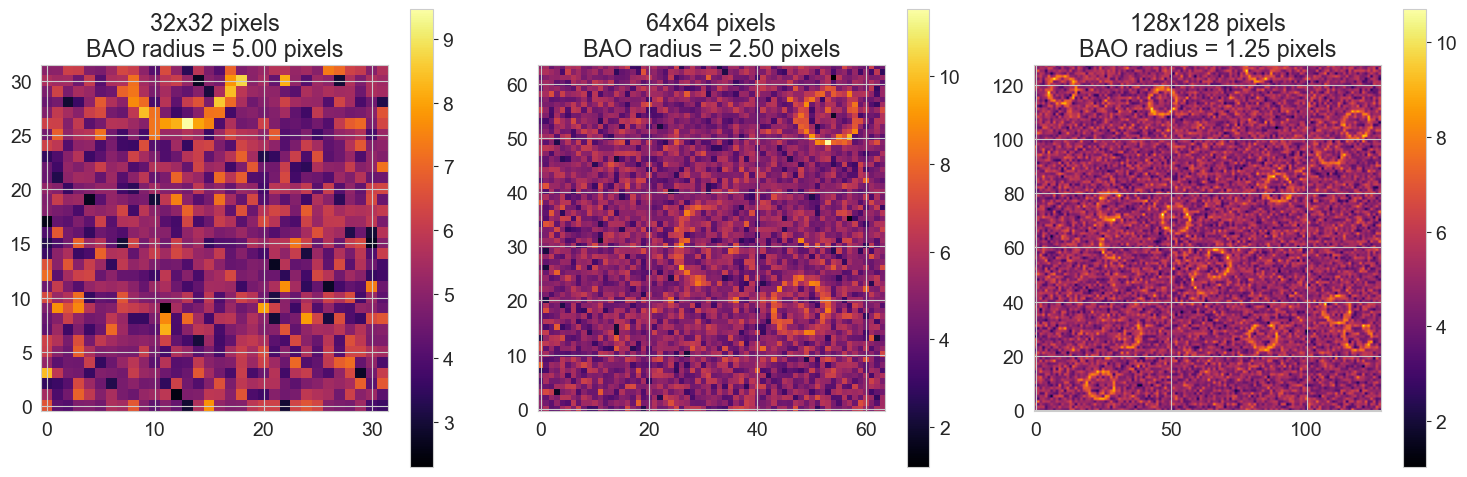

In [6]:
def generate_bao_patch(N=32, **kwargs):
    """Generate a basic 32x32 BAO patch"""
    field = np.random.normal(loc=kwargs.get('base_mean', 5.0), 
                           scale=kwargs.get('noise_std', 1.0), 
                           size=(N, N))
    
    # Add ring with fixed pixel size in our base patch
    pixel_radius = 5.0
    pixel_width = 0.5
    
    # Random center for the ring
    center_x = np.random.uniform(0, N)
    center_y = np.random.uniform(0, N)
    
    x = np.arange(N)
    y = np.arange(N)
    xx, yy = np.meshgrid(x, y)
    rr = np.sqrt((xx - center_x)**2 + (yy - center_y)**2)
    
    ring = kwargs.get('bao_amp', 3.0) * np.exp(-0.5*(
        (rr - pixel_radius)/pixel_width)**2)
    field += ring
    
    return field

def generate_larger_field(N, **kwargs):
    """
    Generate larger field by stitching together 32x32 patches
    
    Parameters:
    -----------
    N : int
        Desired grid size (must be multiple of 32)
    """
    if N % 32 != 0:
        raise ValueError("N must be multiple of 32")
    
    n_patches = N // 32
    
    # Initialize larger field
    large_field = np.zeros((N, N))
    
    # Fill with 32x32 patches
    for i in range(n_patches):
        for j in range(n_patches):
            patch = generate_bao_patch(**kwargs)
            large_field[i*32:(i+1)*32, j*32:(j+1)*32] = patch
    
    return large_field

# Generate and visualize fields of different sizes
sizes = [32, 64, 128]
fig, axes = plt.subplots(1, len(sizes), figsize=(15, 5))

for ax, N in zip(axes, sizes):
    field = generate_larger_field(
        N=N,
        n_rings=int(5 * (N/32)**2),  # scale number of rings with area
        base_mean=5.0,
        bao_amp=3.0,
        noise_std=1.0
    )
    
    im = ax.imshow(field, origin='lower', cmap='inferno')
    ax.set_title(f'{N}x{N} pixels\nBAO radius = {5.0 * (32/N):.2f} pixels')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

In our mock BAO field simulations above, we've created an analogy to real cosmological observations. Each pixel in our images represents a fixed physical area of space, similar to how telescopes maintain consistent angular resolution across their field of view. The BAO phenomenon manifests as a characteristic ring with radius $R_{\text{BAO}} \approx 100$ Mpc/h in the real universe—a fundamental physical scale that remains constant regardless of our observation strategy.
 
To simulate observations of larger sky areas while maintaining numerical precision, we stitch together multiple 32x32 pixel patches. This approach mirrors real cosmological surveys, where observations often consist of different patches of sky that are combined due to inhomogeneous sky coverage. Just as astronomers combine data from different telescope pointings to build a complete survey, we merge these patches while preserving the statistical properties of the BAO signal.
 
As we increase our field size from $N=32$ to $N=128$, the physical BAO ring appears progressively smaller in pixel units. This inverse relationship between field size and pixel radius directly mirrors the behavior in actual cosmological surveys. As we observe larger volumes of the universe, we effectively "zoom out" while maintaining consistent pixel resolution. 

Processing 32x32 fields...
Processing 64x64 fields...
Processing 128x128 fields...


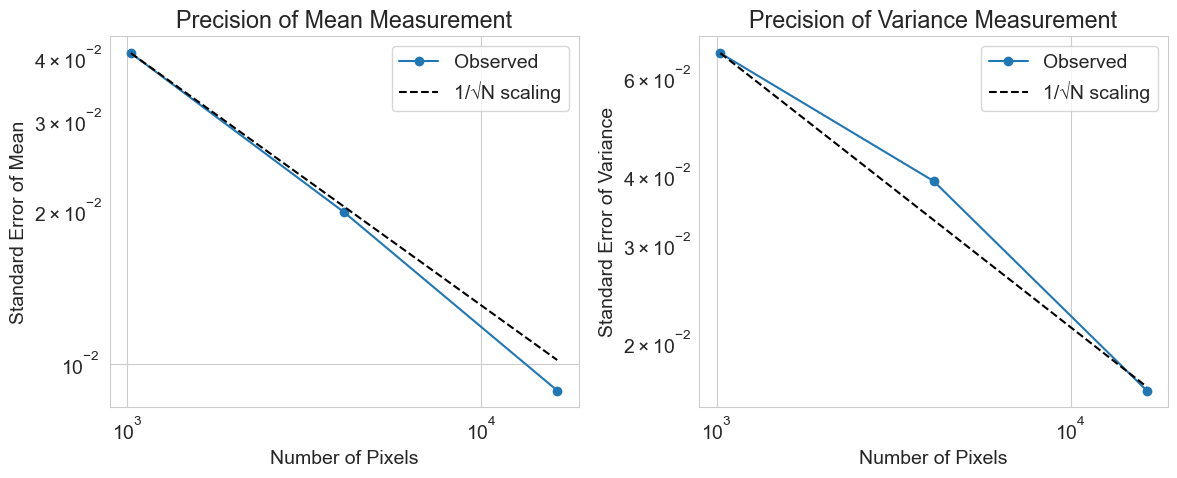


Numerical Results:

Size     Mean±Std.Err.    Variance±Std.Err.
----------------------------------------
32x32:  5.091±0.041  1.185±0.066
64x64:  5.094±0.020  1.189±0.039
128x128:  5.091±0.009  1.189±0.016


In [7]:
# Analyze how statistics change with sample size
sizes = [32, 64, 128]
n_realizations = 100  # Generate multiple realizations for each size
n_bootstrap = 1000    # Bootstrap samples for each realization

# Store results
results = {N: {'means': [], 'variances': []} for N in sizes}

for N in sizes:
    print(f"Processing {N}x{N} fields...")
    
    for _ in range(n_realizations):
        # Generate field
        field = generate_larger_field(
            N=N,
            n_rings=int(5 * (N/32)**2),
            base_mean=5.0,
            bao_amp=3.0,
            noise_std=1.0
        )
        field_flat = field.ravel()
        
        # Bootstrap analysis
        bootstrap_means, bootstrap_vars = bootstrap_statistics(field_flat, n_bootstrap)
        
        # Store results
        results[N]['means'].append(np.mean(field_flat))
        results[N]['variances'].append(np.var(field_flat, ddof=1))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Convert sizes to total number of pixels
N_pixels = np.array(sizes)**2

# Plot distribution of means
mean_std = np.array([np.std(results[N]['means']) for N in sizes])
ax1.loglog(N_pixels, mean_std, 'o-', label='Observed')
ref_line = mean_std[0] * np.sqrt(N_pixels[0]/N_pixels)
ax1.loglog(N_pixels, ref_line, 'k--', label='1/√N scaling')
ax1.set_xlabel('Number of Pixels')
ax1.set_ylabel('Standard Error of Mean')
ax1.set_title('Precision of Mean Measurement')
ax1.grid(True)
ax1.legend()

# Plot distribution of variances
var_std = np.array([np.std(results[N]['variances']) for N in sizes])
ax2.loglog(N_pixels, var_std, 'o-', label='Observed')
ref_line = var_std[0] * np.sqrt(N_pixels[0]/N_pixels)
ax2.loglog(N_pixels, ref_line, 'k--', label='1/√N scaling')
ax2.set_xlabel('Number of Pixels')
ax2.set_ylabel('Standard Error of Variance')
ax2.set_title('Precision of Variance Measurement')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("\nSize     Mean±Std.Err.    Variance±Std.Err.")
print("----------------------------------------")
for N in sizes:
    means = results[N]['means']
    vars = results[N]['variances']
    print(f"{N}x{N}:  {np.mean(means):.3f}±{np.std(means):.3f}  {np.mean(vars):.3f}±{np.std(vars):.3f}")

The plots above demonstrate how the precision of our statistical measurements (mean and variance) improves with increasing sample size. Both the standard error of the mean and the standard error of the variance follow approximately a $1/\sqrt{N}$ scaling law, as shown by the dashed reference lines. This behavior aligns with fundamental statistical principles - when estimating summary statistics from independent and identically distributed (i.i.d.) random variables, the uncertainty in our measurements decreases proportionally to the square root of the sample size. This is because the variance of the sample mean scales as $1/N$, where $N$ is the number of samples (pixels in our case).

## Comparison with Theoretical Expectations

For our analysis, we generated pure Gaussian fields with known parameters (mean $\mu=5.0$, standard deviation $\sigma=1.0$). This allows us to make precise theoretical predictions about our measurements. This gives us clear expectations for both the central value and the spread of our measurements. In the plots below, we will compare these theoretical predictions with our empirical results, examining how well our sample statistics match the expected behavior across different field sizes.

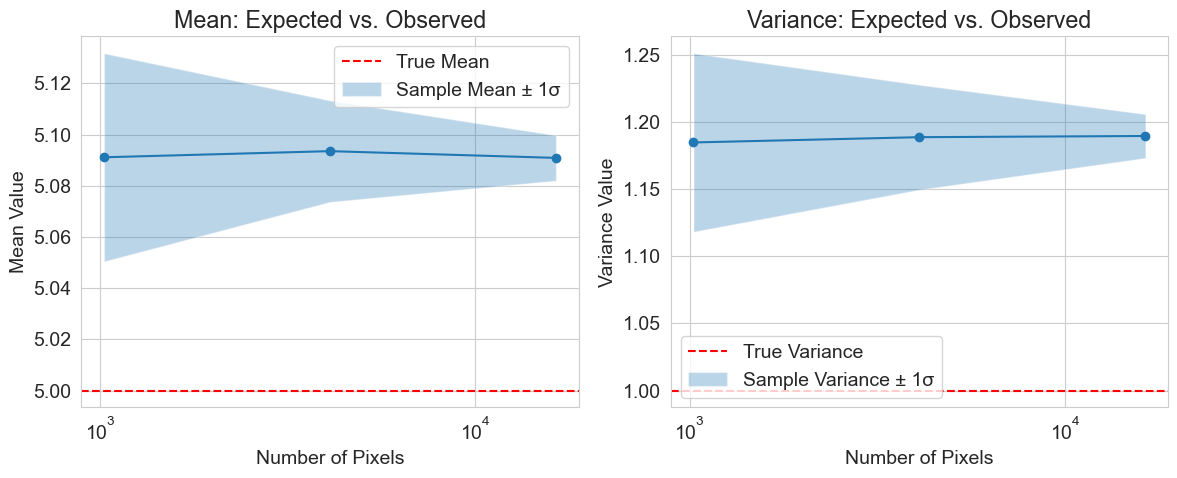

In [8]:
# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Theoretical predictions
N_pixels = np.array(sizes)**2
true_mean = 5.0
true_std = 1.0

# Plot mean comparisons
means = np.array([np.mean(results[N]['means']) for N in sizes])
mean_std = np.array([np.std(results[N]['means']) for N in sizes])

ax1.axhline(y=true_mean, color='r', linestyle='--', label='True Mean')
ax1.fill_between(N_pixels, means - mean_std, means + mean_std, alpha=0.3, label='Sample Mean ± 1σ')
ax1.plot(N_pixels, means, 'o-')
ax1.set_xscale('log')
ax1.set_xlabel('Number of Pixels')
ax1.set_ylabel('Mean Value')
ax1.set_title('Mean: Expected vs. Observed')
ax1.grid(True)
ax1.legend()

# Plot variance comparisons
true_var = true_std**2
variances = np.array([np.mean(results[N]['variances']) for N in sizes])
var_std = np.array([np.std(results[N]['variances']) for N in sizes])

ax2.axhline(y=true_var, color='r', linestyle='--', label='True Variance')
ax2.fill_between(N_pixels, variances - var_std, variances + var_std, alpha=0.3, label='Sample Variance ± 1σ')
ax2.plot(N_pixels, variances, 'o-')
ax2.set_xscale('log')
ax2.set_xlabel('Number of Pixels')
ax2.set_ylabel('Variance Value')
ax2.set_title('Variance: Expected vs. Observed')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

The results above demonstrate that our measurements deviate significantly from what we would expect for pure Gaussian random fields. As we increase the number of pixels $N$, both the mean and variance measurements show systematic offsets from the background-only values, with the statistical significance of these deviations increasing at larger $N$. This increasing statistical power with larger $N$ allows us to more confidently detect and characterize the injected signal component above the background noise.

However, this example represents a simplified limit where we directly injected signal (the ring pattern) on top of background noise. In the real Universe, the BAO phenomenon works differently - it doesn't create additional galaxies.


## More Physically Realistic Simulations
 
Let's take a step back and consider how we can make our simulations more physically accurate. In the real Universe, the BAO effect doesn't add new galaxies to the cosmos - it simply influences how existing galaxies are distributed in space. This means that when we simulate BAO, we need to be careful about conserving both the mean density of galaxies and the overall variance in their distribution.

Our previous approach of simply adding a ring pattern on top of random noise wasn't quite right. Instead, we need to think about redistributing the galaxies in a way that preserves these important statistical properties. The key insight is that we need to adjust our baseline random field to compensate for the statistical properties of the ring pattern we want to add. 

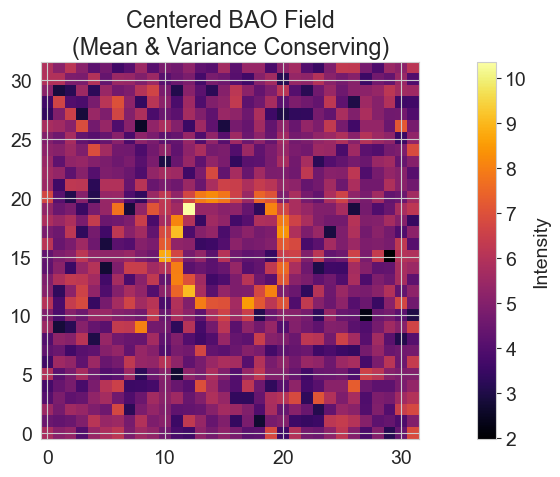

In [9]:
def generate_centered_bao_field_conserving_mean(N=32, base_mean=5.0, r_bao=5.0, 
                                              bao_amp=3.0, bao_width=0.5, noise_std=1.0):
    """
    Generate an N x N pixel field with a centered 'BAO-like' ring that conserves mean and variance.
    
    Parameters:
    -----------
    N : int
        Grid size (N x N pixels)
    base_mean : float
        Target mean intensity of final field
    r_bao : float
        Radius of BAO ring (in pixels)
    bao_amp : float
        Amplitude of BAO signal
    bao_width : float
        Width of BAO ring (in pixels)
    noise_std : float
        Target standard deviation of final field
    """
    x = np.arange(N)
    y = np.arange(N)
    xx, yy = np.meshgrid(x, y)
    
    # Calculate radial distances from center
    cx = cy = (N-1)/2.0  
    rr = np.sqrt((xx - cx)**2 + (yy - cy)**2)
    
    # Generate ring profile first to calculate adjustments needed
    ring_profile = bao_amp * np.exp(-0.5*((rr - r_bao)/bao_width)**2)
    
    # Calculate how much to reduce base_mean and noise_std by
    ring_mean = np.mean(ring_profile)
    ring_std = np.std(ring_profile)
    
    # Adjust baseline parameters to compensate for ring contribution
    adjusted_mean = base_mean - ring_mean
    adjusted_std = np.sqrt(max(noise_std**2 - ring_std**2, 0))  # Prevent negative variance
    
    # Generate baseline field with adjusted parameters
    baseline = np.random.normal(loc=adjusted_mean, scale=adjusted_std, size=(N, N))
    
    # Add ring profile - now total mean and variance will match targets
    field = baseline + ring_profile
    field = np.clip(field, 0, None)  # intensities >= 0
    
    return field

# Illustrate one realization
N = 32
field = generate_centered_bao_field_conserving_mean(N=N)

plt.figure(figsize=(12, 5))

# Plot the field
plt.imshow(field, origin='lower', cmap='inferno')
plt.colorbar(label='Intensity')
plt.title('Centered BAO Field\n(Mean & Variance Conserving)')

plt.tight_layout()
plt.show()

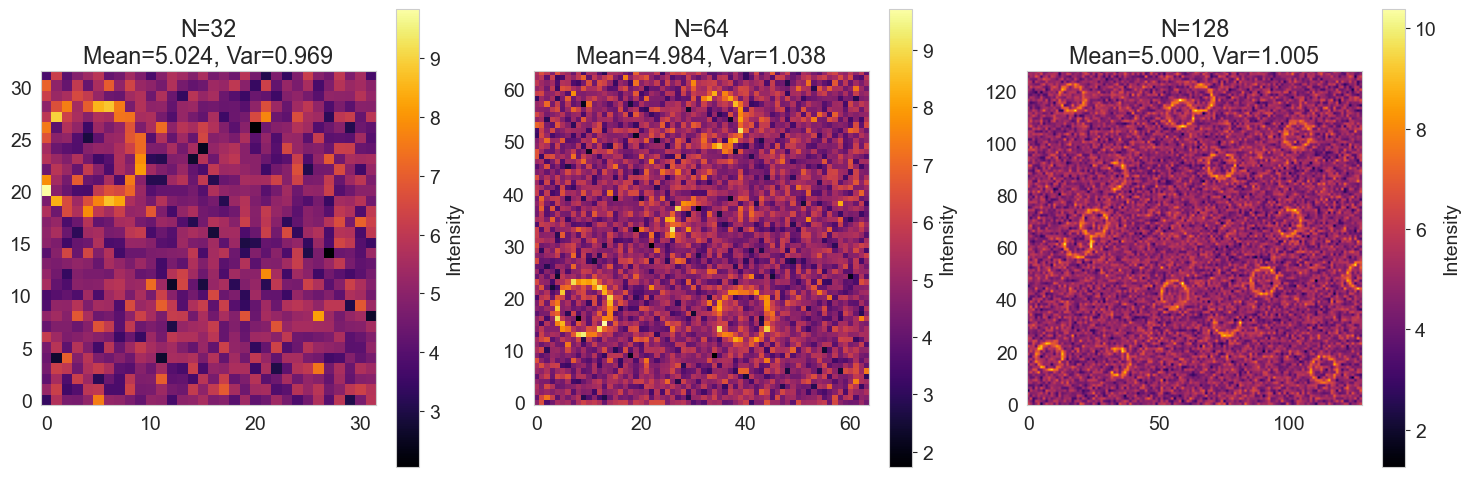

In [10]:
def generate_bao_patch_conserving_mean(N=32, base_mean=5.0, noise_std=1.0,
                                     r_bao=5.0, bao_amp=3.0, bao_width=0.5):
    """
    Generate a basic 32x32 BAO patch that conserves mean and variance
    """
    # Create ring profile first to calculate adjustment needed
    x = np.arange(N)
    y = np.arange(N)
    xx, yy = np.meshgrid(x, y)
    
    # Random center position
    cx = np.random.uniform(0, N)
    cy = np.random.uniform(0, N) 
    rr = np.sqrt((xx-cx)**2 + (yy-cy)**2)
    
    ring_profile = bao_amp * np.exp(-0.5*((rr - r_bao)/bao_width)**2)
    
    # Calculate how much to reduce base_mean and noise_std by
    ring_mean = np.sum(ring_profile) / (N*N)
    ring_std = np.std(ring_profile)
    
    adjusted_mean = base_mean - ring_mean
    adjusted_std = np.sqrt(max(noise_std**2 - ring_std**2, 0))  # Prevent negative variance
    
    # Generate field with reduced mean and std
    field = np.random.normal(loc=adjusted_mean, scale=adjusted_std, size=(N, N))
    
    # Add ring profile - now total mean and variance will match targets
    field += ring_profile
    
    # optional: clip intensities at zero to avoid negative flux
    field = np.clip(field, 0, None)
    
    return field

def generate_larger_field_conserving_mean(N, **kwargs):
    """
    Generate larger field by stitching together 32x32 patches
    
    Parameters:
    -----------
    N : int
        Desired grid size (must be multiple of 32)
    """
    if N % 32 != 0:
        raise ValueError("N must be multiple of 32")
    
    n_patches = N // 32
    
    # Initialize larger field
    large_field = np.zeros((N, N))
    
    # Fill with 32x32 patches
    for i in range(n_patches):
        for j in range(n_patches):
            patch = generate_bao_patch_conserving_mean(**kwargs)
            large_field[i*32:(i+1)*32, j*32:(j+1)*32] = patch
    
    return large_field

# Create figure to show different field sizes
N_values = [32, 64, 128]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, N in enumerate(N_values):
    field = generate_larger_field_conserving_mean(N=N,
                                                base_mean=5.0,
                                                noise_std=1.0,
                                                r_bao=5.0,
                                                bao_amp=3.0,
                                                bao_width=0.5)
    
    mean_global = np.mean(field)
    var_global = np.var(field, ddof=1)
    
    im = axes[i].imshow(field, origin='lower', cmap='inferno')
    plt.colorbar(im, ax=axes[i], label="Intensity")
    axes[i].set_title(f"N={N}\nMean={mean_global:.3f}, Var={var_global:.3f}")
    axes[i].grid(False)

plt.tight_layout()
plt.show()

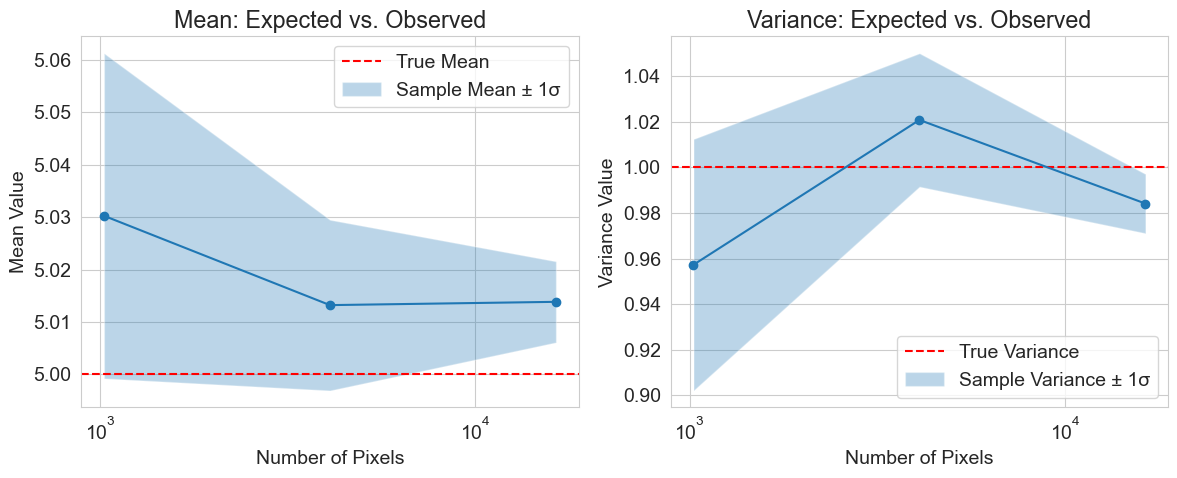

In [11]:
# Repeat bootstrap experiment with conserving field for different N values
N_values = [32, 64, 128]  # Different field sizes to test
N_trials = 1000

# Set up storage for results
results = {}
for N in N_values:
    results[N] = {'means': [], 'variances': []}

# Generate and analyze fields
for N in N_values:
    # Generate field for this N using generate_larger_field_conserving_mean
    field_conserve = generate_larger_field_conserving_mean(N=N,
                                                         base_mean=5.0,
                                                         noise_std=1.0,
                                                         r_bao=5.0,
                                                         bao_amp=3.0,
                                                         bao_width=0.5)
    
    # Perform bootstrap sampling
    for _ in range(N_trials):
        sample = np.random.choice(field_conserve.ravel(), size=N*N, replace=True)
        results[N]['means'].append(np.mean(sample))
        results[N]['variances'].append(np.var(sample, ddof=1))

# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Theoretical predictions
N_pixels = np.array([N*N for N in N_values])
true_mean = 5.0
true_std = 1.0

# Plot mean comparisons
means = np.array([np.mean(results[N]['means']) for N in N_values])
mean_std = np.array([np.std(results[N]['means']) for N in N_values])

ax1.axhline(y=true_mean, color='r', linestyle='--', label='True Mean')
ax1.fill_between(N_pixels, means - mean_std, means + mean_std, alpha=0.3, label='Sample Mean ± 1σ')
ax1.plot(N_pixels, means, 'o-')
ax1.set_xscale('log')
ax1.set_xlabel('Number of Pixels')
ax1.set_ylabel('Mean Value')
ax1.set_title('Mean: Expected vs. Observed')
ax1.grid(True)
ax1.legend()

# Plot variance comparisons
true_var = true_std**2
variances = np.array([np.mean(results[N]['variances']) for N in N_values])
var_std = np.array([np.std(results[N]['variances']) for N in N_values])

ax2.axhline(y=true_var, color='r', linestyle='--', label='True Variance')
ax2.fill_between(N_pixels, variances - var_std, variances + var_std, alpha=0.3, label='Sample Variance ± 1σ')
ax2.plot(N_pixels, variances, 'o-')
ax2.set_xscale('log')
ax2.set_xlabel('Number of Pixels')
ax2.set_ylabel('Variance Value')
ax2.set_title('Variance: Expected vs. Observed')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

When we generate the BAO structure in a physically meaningful way by conserving total flux (adding and subtracting equal amounts), simple statistical measures like the mean and variance fail to detect the signal. The mean stays anchored near its original value $\approx 5$ and the variance remains close to its baseline $\approx 1$ because the local fluctuations balance out globally.

This failure of one-point statistics (measures that treat each pixel as an independent sample) teaches us an important lesson about the nature of the BAO signal. The key physical insight is that BAO creates spatially correlated structures - specifically rings of a characteristic size. To detect such patterns, we need statistical tools that can capture how values at different spatial positions relate to each other.

This naturally leads us to consider two-point statistics, such as correlation functions and covariance analyses. These tools explicitly measure the relationship between pairs of pixels separated by various distances. This approach aligns more closely with actual BAO analysis techniques used in modern cosmology. But before diving into complex correlation functions, let's build our intuition by starting with a simpler case.

## Two-Point Statistics

Let's start with a simple case again where we have a centered ring pattern with properly conserved the mean and variance:

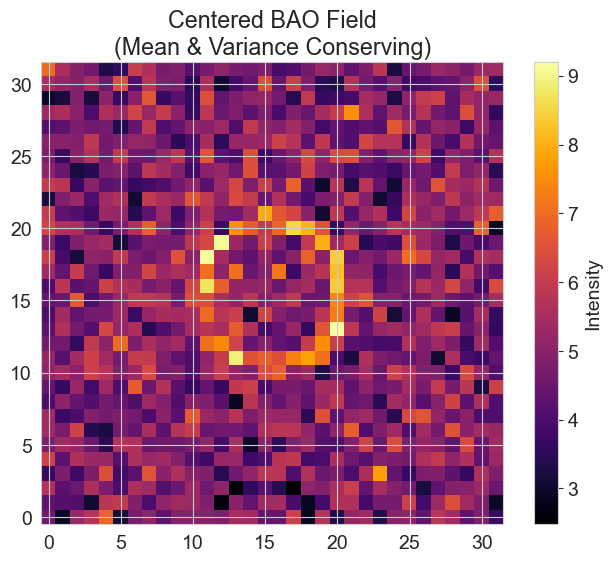

In [12]:
# Generate example with clear ring
field = generate_centered_bao_field_conserving_mean(
    N=32, 
    base_mean=5.0, 
    r_bao=5.0,
    bao_amp=3.0,  # Making it more visible for illustration
    bao_width=0.5,
    noise_std=1.0
)

# Plot the field
plt.imshow(field, origin='lower', cmap='inferno')
plt.colorbar(label='Intensity')
plt.title('Centered BAO Field\n(Mean & Variance Conserving)')
plt.show()

In any single image, the ring might be hard to see due to noise. However, when we examine multiple images together, interesting patterns begin to emerge. The pixels that lie along the ring structure tend to vary in brightness together - when one part of the ring brightens, other parts often follow suit. This coordinated behavior extends even to pixels that sit exactly opposite each other across the ring's diameter, as they too tend to brighten and dim in unison. Meanwhile, pixels that fall far from the ring structure show no particular relationship to each other, varying independently in their brightness.

This systematic relationship between pairs of pixels provides the key insight that leads us to correlation analysis. Rather than focusing on individual pixel values in isolation, we need to study how pairs of pixels behave together to reveal the underlying ring structure.


## Introducing the Correlation Matrix

For any two pixels in our image, we can ask: "When one pixel is brighter than average, does the other pixel tend to be brighter too?" This is exactly what a correlation measures. Mathematically, for pixels $(i,j)$ and $(k,\ell)$:

$C_{ij,k\ell} = \frac{\text{Cov}(X_{ij}, X_{k\ell})}{\sqrt{\text{Var}(X_{ij})\text{Var}(X_{k\ell})}}$

where:
- $X_{ij}$ is the value at pixel $(i,j)$
- $\text{Cov}(X_{ij}, X_{k\ell})$ is how much the pixels vary together
- $\text{Var}(X_{ij})$ and $\text{Var}(X_{k\ell})$ are how much each pixel varies individually

A correlation of:
- +1 means the pixels always brighten and dim together
- 0 means the pixels vary independently
- -1 means when one brightens, the other dims

To estimate these correlations from data, we need multiple realizations (images) of our field. In cosmology, this is analogous to surveying different patches of the sky to study galaxy distributions and detect the BAO signal - each patch represents a different realization:

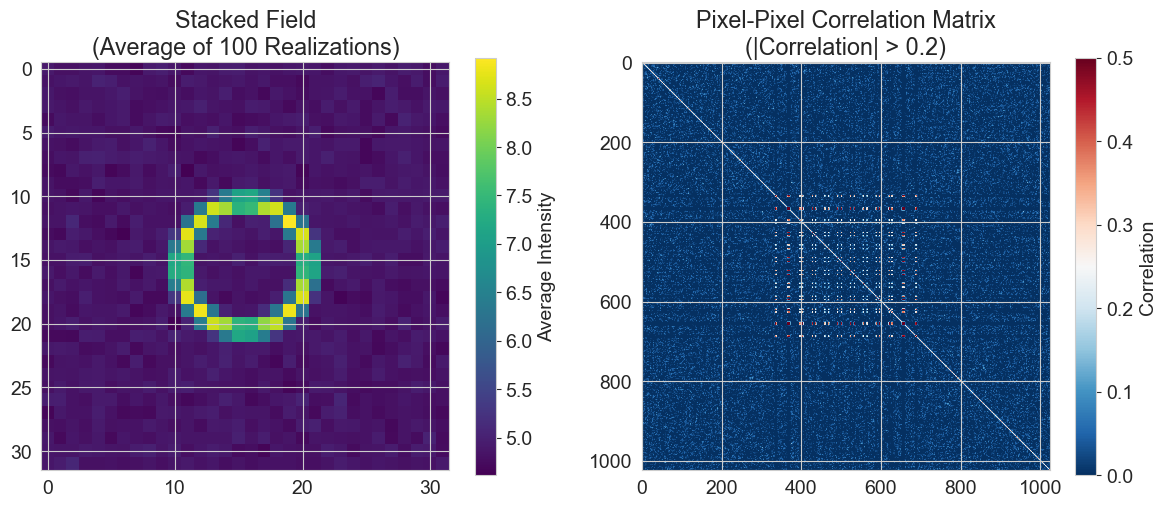


Correlation Statistics:
  Mean correlation: 0.002
  Std deviation: 0.127
  Fraction of strong correlations (|corr| > 0.2): 10.0%


In [13]:
def generate_realizations(n_realizations=100, N=32, base_mean=5.0, 
                         r_bao=5.0, bao_width=0.5, noise_std=1.0):
    """
    Generate multiple realizations of fields with centered BAO rings
    """
    realizations = []
    # Use random amplitudes to simulate varying ring strengths
    for _ in range(n_realizations):
        # Random amplitude between 1.0 and 7.0
        random_amp = np.random.uniform(1.0, 7.0)
        field = generate_centered_bao_field_conserving_mean(
            N=N, 
            base_mean=base_mean, 
            r_bao=r_bao,
            bao_amp=random_amp,
            bao_width=bao_width,
            noise_std=noise_std
        )
        realizations.append(field)
    return np.array(realizations)

def compute_pixel_correlations(realizations):
    """
    Compute correlation matrix between all pixels
    """
    # Reshape to 2D array: (n_realizations, n_pixels)
    n_real, ny, nx = realizations.shape
    reshaped = realizations.reshape(n_real, -1)
    
    # Compute correlation matrix
    correlation_matrix = np.corrcoef(reshaped.T)
    return correlation_matrix

def visualize_correlations(realizations, correlation_matrix, threshold=0.2):
    """
    Create side-by-side visualization of:
    1. Stacked (averaged) field
    2. Correlation matrix (thresholded for clarity)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot stacked field
    stacked_field = np.mean(realizations, axis=0)
    im1 = ax1.imshow(stacked_field, cmap='viridis')
    ax1.set_title('Stacked Field\n(Average of {} Realizations)'.format(len(realizations)))
    plt.colorbar(im1, ax=ax1, label='Average Intensity')
    
    # Plot thresholded correlation matrix
    correlation_matrix_clipped = np.where(
        np.abs(correlation_matrix) > threshold, 
        correlation_matrix, 
        0
    )
    im2 = ax2.imshow(correlation_matrix_clipped, cmap='RdBu_r',
                     vmin=0, vmax=0.5)
    ax2.set_title(f'Pixel-Pixel Correlation Matrix\n(|Correlation| > {threshold})')
    plt.colorbar(im2, ax=ax2, label='Correlation')
    
    plt.tight_layout()
    return fig, (ax1, ax2)

# Generate data and create visualization
n_realizations = 100
N = 32
realizations = generate_realizations(n_realizations, N)

# Compute correlation matrix
correlation_matrix = compute_pixel_correlations(realizations)

# Create visualization
fig, axes = visualize_correlations(realizations, correlation_matrix)
plt.show()

# Print some statistics about the correlations
correlations = correlation_matrix[correlation_matrix != 1.0]  # Exclude self-correlations
print(f"\nCorrelation Statistics:")
print(f"  Mean correlation: {correlations.mean():.3f}")
print(f"  Std deviation: {correlations.std():.3f}")
print(f"  Fraction of strong correlations "
      f"(|corr| > 0.2): {(np.abs(correlations) > 0.2).mean():.1%}")

The core idea here is to generate many versions of our field and analyze how different parts of the image relate to each other across multiple observations.

The first panel shows our stacked field, created by averaging all realizations:

$\bar{X}_{ij} = \frac{1}{N_\mathrm{real}} \sum_{n=1}^{N_\mathrm{real}} X^{(n)}_{ij}$

where $X^{(n)}_{ij}$ is the value at pixel $(i,j)$ in realization $n$. This stacking technique is powerful because the random noise in each pixel follows $\mathcal{N}(0, \sigma^2)$. When we average $N_\mathrm{real}$ independent noise realizations, the variance reduces to $\text{Var}(\bar{X}_{ij}) = \frac{\sigma^2}{N_\mathrm{real}}$. Therefore, the noise level in our stacked image is reduced by a factor of $\sqrt{N_\mathrm{real}} = 10$, while the ring signal (being consistent in position) maintains its strength. This explains why the ring pattern becomes so clear in our stacked image.

For our correlation analysis, we first compute the covariance between pixels (i,j) and (k,ℓ):

$\mathrm{Cov}_{ij,k\ell} = \sum_{n=1}^{N_\mathrm{real}} (X^{(n)}_{ij} - \bar{X}_{ij})(X^{(n)}_{k\ell} - \bar{X}_{k\ell})$

And the variance for each pixel:

$\mathrm{Var}_{ij} = \sum_{n=1}^{N_\mathrm{real}} (X^{(n)}_{ij} - \bar{X}_{ij})^2$

The correlation coefficient is then:

$C_{ij,k\ell} = \frac{\mathrm{Cov}_{ij,k\ell}}{\sqrt{\mathrm{Var}_{ij}\mathrm{Var}_{k\ell}}}$

The second panel shows this correlation matrix, with pixels indexed in row-major order. This means pixel $(i,j)$ maps to index $k = i \times N + j$. The grid lines in the correlation matrix mark boundaries between rows in our original image, and the diagonal line represents self-correlations (always 1.0).

The grid-like pattern we observe in the correlation matrix emerges because pixels that lie along the ring in the same row of the image end up separated by consistent distances in our flattened index space. However, this visualization actually obscures some of the ring's structure because physically adjacent pixels that lie in different rows become separated in the correlation matrix.

This suggests we might want to organize our analysis differently - perhaps by looking at correlations between pixels based on their physical separation rather than their array indices. This leads us naturally to the concept of radial correlations, which we'll explore next.

## Radial Correlation Analysis

Our previous correlation matrix, while informative, wasn't ideally suited for analyzing a circular pattern. Since we know the BAO signal creates a ring-like feature, it makes more sense to analyze our data in terms of radial distances from the center.

Instead of working with individual pixels, we'll group pixels based on their distance from the center. For any pixel at position $(i,j)$, we can calculate its radial distance:

$r_{ij} = \sqrt{(i - i_c)^2 + (j - j_c)^2}$

where $(i_c, j_c)$ is the center of our image.

We divide our possible radial distances into consecutive bins, starting from the center:
$0 \leq r < \Delta r$ for bin 0, $\Delta r \leq r < 2\Delta r$ for bin 1, and so on.

For each radial bin $k$, we compute its average intensity:
 
$\delta_k = \frac{1}{N_k} \sum_{r_{ij} \in \mathrm{bin}_k} X_{ij}$
 
where $N_k$ is the number of pixels in bin $k$. As discussed in the lecture, since $\delta_k$ is a sum of random variables (the pixel intensities), it is itself a random variable with its own probability distribution.

Radial binning naturally respects the circular symmetry of our signal while reducing noise through pixel averaging. This approach makes patterns at the characteristic BAO scale more apparent. Additionally, it simplifies our correlation analysis by reducing thousands of pixel correlations down to correlations between just a few dozen radial bins.

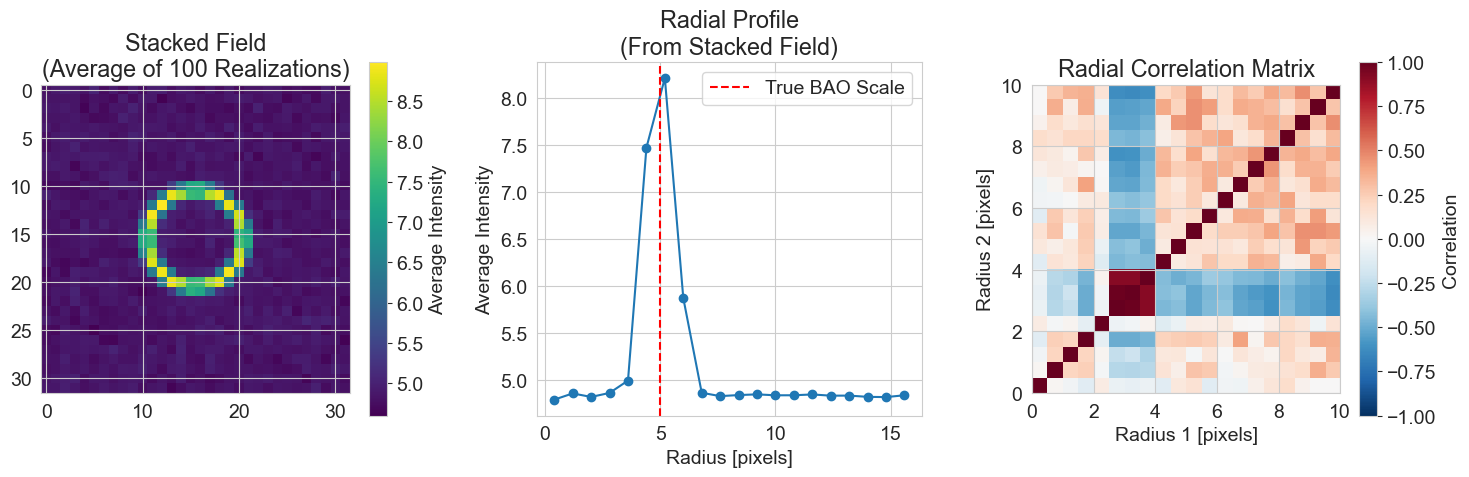


Radial Correlation Statistics:
  Mean correlation: 0.034
  Std deviation: 0.322
  Min correlation: -0.636
  Max correlation: 0.980


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def compute_radial_bins(field, n_bins=20, r_max=None):
    """
    Compute average intensity in radial bins
    
    Parameters:
    -----------
    field : 2D array
        Input field
    n_bins : int
        Number of radial bins
    r_max : float or None
        Maximum radius to consider. If None, use half the image size.
    
    Returns:
    --------
    bin_edges : array
        Edges of the radial bins
    bin_centers : array
        Centers of the radial bins
    radial_profile : array
        Average intensity in each radial bin
    """
    ny, nx = field.shape
    y, x = np.indices((ny, nx))
    
    # Calculate center and radial distances
    center = ((ny-1)/2., (nx-1)/2.)
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    
    # Set up binning
    if r_max is None:
        r_max = min(ny, nx)/2.
    
    bin_edges = np.linspace(0, r_max, n_bins + 1)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    # Compute radial profile
    radial_profile = np.zeros(n_bins)
    for i in range(n_bins):
        mask = (r >= bin_edges[i]) & (r < bin_edges[i+1])
        if mask.any():
            radial_profile[i] = field[mask].mean()
            
    return bin_edges, bin_centers, radial_profile

def compute_radial_correlation_matrix(realizations, n_bins=20):
    """
    Compute correlation matrix between radial bins across realizations
    """
    n_real = len(realizations)
    radial_profiles = np.zeros((n_real, n_bins))
    
    # Compute radial profiles for all realizations
    for i, field in enumerate(realizations):
        _, _, profile = compute_radial_bins(field, n_bins=n_bins)
        radial_profiles[i] = profile
    
    # Compute correlation matrix
    correlation_matrix = np.corrcoef(radial_profiles.T)
    return correlation_matrix

# Generate data
n_realizations = 100
N = 32
realizations = generate_realizations(n_realizations, N)

# Compute radial correlation matrix
n_bins = 20
radial_corr = compute_radial_correlation_matrix(realizations, n_bins=n_bins)

# Create visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot stacked field
stacked_field = np.mean(realizations, axis=0)
im1 = ax1.imshow(stacked_field, cmap='viridis')
ax1.set_title('Stacked Field\n(Average of {} Realizations)'.format(n_realizations))
plt.colorbar(im1, ax=ax1, label='Average Intensity')

# Plot example radial profile
_, bin_centers, radial_profile = compute_radial_bins(stacked_field, n_bins=n_bins)
ax2.plot(bin_centers, radial_profile, 'o-')
ax2.axvline(5.0, color='r', linestyle='--', label='True BAO Scale')
ax2.set_xlabel('Radius [pixels]')
ax2.set_ylabel('Average Intensity')
ax2.set_title('Radial Profile\n(From Stacked Field)')
ax2.legend()
ax2.grid(True)

# Plot radial correlation matrix
im3 = ax3.imshow(radial_corr, origin='lower', cmap='RdBu_r', 
                 extent=[0, 10, 0, 10], vmin=-1, vmax=1)
ax3.set_title('Radial Correlation Matrix')
ax3.set_xlabel('Radius 1 [pixels]')
ax3.set_ylabel('Radius 2 [pixels]')
plt.colorbar(im3, ax=ax3, label='Correlation')

plt.tight_layout()
plt.show()

# Print statistics about radial correlations
diag_mask = ~np.eye(radial_corr.shape[0], dtype=bool)
radial_corrs = radial_corr[diag_mask]

print("\nRadial Correlation Statistics:")
print(f"  Mean correlation: {radial_corrs.mean():.3f}")
print(f"  Std deviation: {radial_corrs.std():.3f}")
print(f"  Min correlation: {radial_corrs.min():.3f}")
print(f"  Max correlation: {radial_corrs.max():.3f}")

The stacked field (left panel) displays the average of all realizations, where the ring pattern becomes clearly visible due to noise reduction by a factor of $\sqrt{N_\mathrm{real}} = 10$.
 
The radial profile (middle panel) plots average intensity against radius, with a notable peak at $r \approx 5$ pixels corresponding to the BAO ring. A red dashed line marks the true BAO scale.
 
The radial correlation matrix (right panel) reveals correlations between different radii. A strong band at $r_1 = r_2 \approx 5$ pixels indicates that pixels at the BAO radius are strongly correlated with each other. Note that we omit the diagonal elements of the correlation matrix since they are always equal to 1 by definition. This is because for any random variable X, its correlation with itself is:
 
$\rho_{XX} = \frac{Cov(X,X)}{σ_X σ_X} = \frac{Var(X)}{σ_X^2} = 1$
 
This radial analysis makes the BAO signal much more apparent by respecting circular symmetry, reducing noise through radial averaging, and presenting correlations in terms of physical distances rather than pixel indices.

## BAO in Cosmological Surveys and Two-Point Correlation Analysis

Our simplified model of BAO detection has helped establish basic statistical principles, but real cosmological BAO analysis involves considerably more complexity. In reality, BAO shells can appear at any random locations, creating a superposition of many overlapping shells, rather than the single centered rings we've worked with so far. The correlation function we measure effectively averages over all these possible centers, providing a statistical view of the overall structure.

To bridge this gap between our toy model and reality, we'll now simulate multiple overlapping rings with random centers. The key tool for analyzing such patterns is the two-point correlation function, which measures the excess probability (compared to random) of finding pairs of points separated by a given distance. For a field $\delta(\mathbf{x})$ representing fluctuations around the mean, the two-point correlation function is defined as:
 
$\xi(\mathbf{r}) = \langle \delta(\mathbf{x})\delta(\mathbf{x}+\mathbf{r}) \rangle_{\mathbf{x}}$
 
where $\delta(\mathbf{x}) = \frac{f(\mathbf{x}) - \bar{f}}{\bar{f}}$ is the density contrast, $\mathbf{r}$ is the separation vector, and $\langle \cdot \rangle$ denotes an ensemble average. Note that $\mathbf{x}$ represents any location in the field - by averaging over all possible positions $\mathbf{x}$, we avoid assuming any special center point in our analysis.

In BAO analysis, we're particularly interested in how this function depends on the separation distance $r = |\mathbf{r}|$. Computing this requires converting our intensity field to density contrast ($\delta_{ij} = \frac{X_{ij} - \bar{X}}{\bar{X}}$) and then finding all pairs of pixels separated by each distance $r \pm \Delta r/2$ to compute their average product. 

In [15]:
from scipy.stats import binned_statistic

def compute_two_point_correlation(field, r_edges, subtract_mean=True):
    N = field.shape[0]
    
    # Center the field
    if subtract_mean:
        field = field - np.mean(field)
    
    # Get all pixel coordinates
    y, x = np.indices((N, N))
    coords = np.column_stack((x.ravel(), y.ravel()))
    vals = field.ravel()
    
    # Get unique pairs
    triu_indices = np.triu_indices(N*N, k=1)
    
    # Compute distances and products
    dr = np.sqrt((coords[triu_indices[0], 0] - coords[triu_indices[1], 0])**2 +
                (coords[triu_indices[0], 1] - coords[triu_indices[1], 1])**2)
    products = vals[triu_indices[0]] * vals[triu_indices[1]]
    
    # Bin by distance
    xi_r, _, _ = binned_statistic(dr, products, bins=r_edges, statistic='mean')
    
    return xi_r

In [16]:
from tqdm import tqdm_notebook

def correlation_analysis(realizations, n_rbins=30, r_max=None, n_bootstrap=100):
    N_real, N, _ = realizations.shape
    
    # Set up radial bins
    if r_max is None:
        r_max = np.sqrt(2) * N / 2
    r_edges = np.linspace(0, r_max, n_rbins + 1)
    r_centers = 0.5 * (r_edges[:-1] + r_edges[1:])
    
    # Compute correlations for all fields once
    print("Computing correlations for all fields...")
    xi_all = []
    for i in range(N_real):
        xi = compute_two_point_correlation(realizations[i], r_edges)
        xi_all.append(xi)
    xi_all = np.array(xi_all)
    
    # Mean correlation from original set
    xi_mean = np.mean(xi_all, axis=0)
    
    # Bootstrap at field level using pre-computed correlations
    print("Bootstrapping...")
    xi_boot = []
    for _ in tqdm_notebook(range(n_bootstrap)):
        # Create bootstrap sample by selecting from pre-computed correlations
        boot_idx = np.random.randint(0, N_real, size=N_real)
        boot_sample = xi_all[boot_idx]  # Using pre-computed correlations
        xi_boot.append(np.mean(boot_sample, axis=0))
    
    xi_boot = np.array(xi_boot)
    xi_std = np.std(xi_boot, axis=0)
    
    return r_centers, xi_mean, xi_std

Computing correlations for all fields...
Bootstrapping...


/var/folders/qx/jfbmm9vj13vgmv01k0sz51400000gn/T/ipykernel_65706/1184977569.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(n_bootstrap)):


  0%|          | 0/100 [00:00<?, ?it/s]

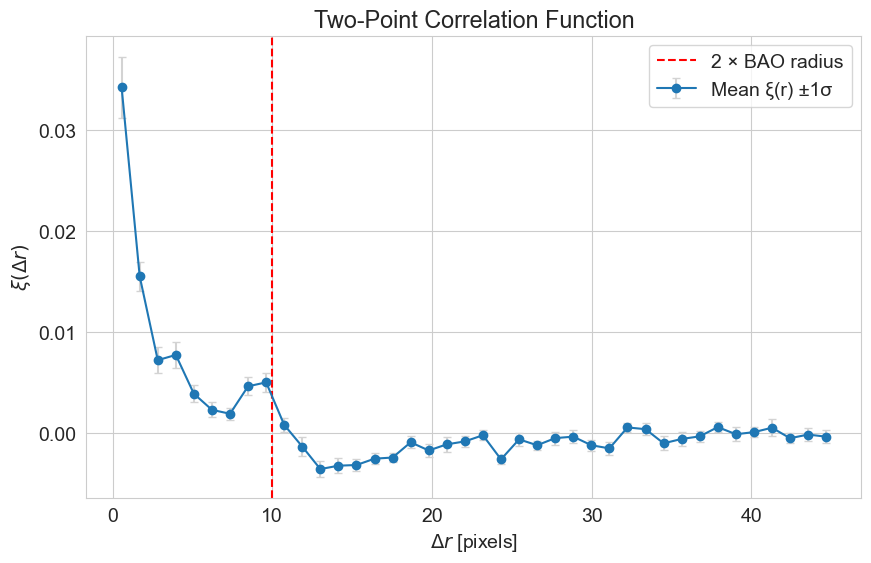


Correlation Function Statistics:
Peak location: 9.6 pixels
Expected peak (2×R): 10.0 pixels


In [17]:
# Generate multiple realizations
N = 64
N_realizations = 20
all_fields = []

for _ in range(N_realizations):
    field = generate_larger_field_conserving_mean(
        N=N,
        base_mean=5.0,
        noise_std=1.0,
        r_bao=5.0,      # Ring radius of 5 pixels
        bao_amp=1.5,
        bao_width=0.5
    )
    all_fields.append(field)
all_fields = np.array(all_fields)

# Compute correlation function
r_centers, xi_mean, xi_std = correlation_analysis(
    all_fields, n_rbins=40, r_max=np.sqrt(2)*N/2
)

# Create visualization
plt.figure(figsize=(10, 6))
plt.errorbar(r_centers, xi_mean, yerr=xi_std, fmt='o-', 
            ecolor='lightgray', capsize=3, label='Mean ξ(r) ±1σ')
plt.axvline(10.0, color='r', linestyle='--', 
            label='2 × BAO radius')  # Peak at diameter = 2R
plt.xlabel(r'$\Delta r$ [pixels]')
plt.ylabel(r'$\xi(\Delta r)$')
plt.title('Two-Point Correlation Function')
plt.grid(True)
plt.legend()
plt.show()

# Print statistics
peak_mask = (r_centers > 5) & (r_centers < 15)  # Look near expected peak
peak_idx = np.argmax(xi_mean[peak_mask]) + np.where(peak_mask)[0][0]
print("\nCorrelation Function Statistics:")
print(f"Peak location: {r_centers[peak_idx]:.1f} pixels")
print(f"Expected peak (2×R): 10.0 pixels")

Looking at the correlation function plot, we observe several key features across different distance scales. At small separations ($\Delta r < 3$), we see strong positive correlations because nearby pixels in the ring pattern are necessarily similar in value. The ring pattern's finite width ($\sigma_{BAO} = 0.5$ pixels) creates a smooth decline in correlations moving away from zero separation.
 
The most interesting region is at intermediate scales ($3 < \Delta r < 15$), where our BAO signal appears. We observe a clear peak at $\Delta r \approx 10$ pixels, corresponding to $2 \times r_{BAO}$ (with $r_{BAO} = 5$). This peak represents the most common separation between overdense regions, with its width determined by both our ring width and random overlaps. At large separations ($\Delta r > 15$), the correlation function approaches zero as points far apart become uncorrelated, matching our physical intuition about the BAO pattern's characteristic scale.

The error bars in our correlation function represent statistical uncertainties estimated through bootstrap resampling. For each bootstrap iteration, we randomly select $N_\mathrm{real}$ fields from our set of realizations with replacement and compute the correlation function. By repeating this process $N_\mathrm{bootstrap} = 100$ times, we build up a distribution of possible correlation values at each separation $\Delta r$. The error bars show the standard deviation of these bootstrap samples, providing a robust estimate of measurement uncertainty without assuming any particular probability distribution. 

Note that in this demonstration, we observe relatively small error bars because we've chosen the BAO signal amplitude to be comparable to the background fluctuations for clarity. In real cosmological surveys, the BAO signal is much more subtle compared to background noise, typically requiring either very large survey volumes (large $N$) or deeper observations (reduced noise) to achieve a statistically significant detection. This highlights why modern BAO studies rely on massive galaxy surveys covering substantial portions of the sky.



## Conclusion

In this tutorial, we've explored the fundamental concepts behind BAO detection through statistical analysis:

1. We learned how to handle one-point statistics in galaxy surveys, understanding their limitations in detecting subtle spatial patterns
2. We explored two-point statistics and correlation functions as powerful tools for detecting characteristic scales
3. We demonstrated how bootstrapping provides robust uncertainty estimates in cosmological measurements

These techniques form the foundation for modern cosmological analysis, particularly in studying the large-scale structure of the universe.

### Food for thought and further reading

1. Try different ring widths and amplitudes to see how they affect the detectability of the BAO signal
2. Implement power spectrum analysis as an alternative to correlation functions. Which method is more sensitive to the BAO signal and why?
3. Compare the computational efficiency of different correlation function estimators (direct pair counting vs. FFT methods)
4. Design false detection studies to understand the significance of BAO measurements. What signal-to-noise ratio is needed for a reliable detection?
5. Real galaxy surveys have additional complications like redshift-space distortions and evolving galaxy bias. How might these affect BAO measurements?